In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
import itertools
import collections
import datetime

from scripts.plot import plot_from_files

plt.rcParams['text.usetex'] = True

def head_and_tail(xs, n=5):
    if len(xs) <= 2*n:
        return xs
    return xs[:n] + ["..."] + xs[-n:]

def df_show_all_rows(df):
    with pd.option_context('display.max_rows', None):
        display(df)

def unique_rows(df):
    return df.drop_duplicates(ignore_index=True)

CYAN = '#00B9F2' # cyan
MAGENTA = '#BF3EFF' # DarkOrchid1
YELLOW = '#CDAD00' #Gold3

In [2]:
def load_stats(path):
    return pd.read_table(path, names=['k', 'n', 'c', 'min', 'max', 'star', 'count'], sep=' ')

def load_k(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2', 'count'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2', 'b3', 'b4', 'b5', 'count'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=[
            'n',
            'a',
            'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
            'c1', 'c2', 'c3',
            'd1', 'd2', 'd3',
            'e1', 'e2',
            'count',
        ], sep=' ')
    if k == 7:
        return pd.read_table(path, names=[
            'n',
            'a',
            'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
            'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
            'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7',
            'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7',
            'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
            'count',
        ], sep=' ')
    raise NotImplementedError

def load_kss(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b', 'count'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b', 'count'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=['n', 'a', 'b', 'c', 'd', 'e', 'count'], sep=' ')
    if k == 7:
        return pd.read_table(path, names=['n', 'a', 'b', 'c', 'd', 'e', 'f', 'count'], sep=' ')
    raise NotImplementedError

df_stats_c2m2dP = load_stats('computed/counts-stats-c2m2dP-30-1.txt.gz')
df_stats_dP = load_stats('computed/counts-stats-dP-30-1.txt.gz')

df_k4_c2m2dP4 = load_k(4, 'computed/counts-k4-c2m2dP4-30-1.txt.gz')
df_k5_c2m2dP5 = load_k(5, 'computed/counts-k5-c2m2dP5-30-1.txt.gz')
df_k6_c2m2dP6 = load_k(6, 'computed/counts-k6-c2m2dP6-30-1.txt.gz')
df_k4_dP4 = load_k(4, 'computed/counts-k4-dP4-30-1.txt.gz')
df_k5_dP5 = load_k(5, 'computed/counts-k5-dP5-30-1.txt.gz')
df_k6_dP6 = load_k(6, 'computed/counts-k6-dP6-30-1.txt.gz')

# The Dimension of the Coloring/Coefficent Space

In [3]:
def get_partitions(k):
    for p in sage.combinat.set_partition.SetPartitions(range(k)):
        if p.is_noncrossing() and 1 not in map(len, p):
            yield p

def is_color_parity_correct(cs, indices):
    counts = [0, 0, 0]
    for i in indices:
        counts[cs[i]] += 1
    return counts[0] % 2 == counts[1] % 2 == counts[2] % 2

def is_minimal_coloring(cs):
    i0 = cs.index(0) if 0 in cs else len(cs)
    i1 = cs.index(1) if 1 in cs else len(cs)
    i2 = cs.index(2) if 2 in cs else len(cs)
    return i0 <= i1 <= i2

def get_colorings(k):
    for cs in itertools.product([0, 1, 2], repeat=k):
        if is_color_parity_correct(cs, range(k)) and is_minimal_coloring(cs):
            yield cs

def is_compatible(p, cs):
    return all(is_color_parity_correct(cs, s) for s in p)

# for k in range(2, 14):
for k in range(2, 11):
    partitions = list(get_partitions(k))
    colorings = list(get_colorings(k))
    M = matrix(ZZ, len(colorings), len(partitions))
    for i, cs in enumerate(colorings):
        for j, p in enumerate(partitions):
            M[i, j] = is_compatible(p, cs)
    rank = M.rank()
    print(f'k={k:<2} colorings{len(colorings):<5} partitions={len(partitions):<5} fullrank={rank==len(partitions)}')

k=2  colorings1     partitions=1     fullrank=True
k=3  colorings1     partitions=1     fullrank=True
k=4  colorings4     partitions=3     fullrank=True
k=5  colorings10    partitions=6     fullrank=True
k=6  colorings31    partitions=15    fullrank=True
k=7  colorings91    partitions=36    fullrank=True
k=8  colorings274   partitions=91    fullrank=True
k=9  colorings820   partitions=232   fullrank=True
k=10 colorings2461  partitions=603   fullrank=True


Isn't the rank even lower for real graphs? ... no:

In [4]:
for k in [4, 5, 6, 7]:
    points = load_k(k, f'computed/counts-k{k}-dP{k}-30-1.txt.gz')
    points = points[k + points.n == 26].drop(columns=['n', 'count'])
    points = unique_rows(points)
    M = matrix(ZZ, points.to_numpy())
    rank = M.rank()
    print(k, len(points.columns), rank)

4 3 3
5 6 6
6 15 15
7 36 36


# Theoretical Constraints Given by Coloring Count Non-negativity

In [5]:
def rotate_partition(k, p, i):
    rp = sorted(sorted((x+i)%k for x in s) for s in p)
    return sage.combinat.set_partition.SetPartition(rp)

def canonicalize_partition(k, p):
    return min(rotate_partition(k, p, i) for i in range(k))

def rotate_coloring(cs, i):
    return tuple(cs[i:] + cs[:i])

def canonicalize_coloring(k, cs):
    all_reprs = []
    for perm in itertools.permutations(range(3)):
        for rot in [rotate_coloring(cs, i) for i in range(k)]:
            all_reprs.append(tuple(perm[c] for c in rot))
    return min(all_reprs)

for k, canon in [
    (4, False),
    (4, True),
    (5, False),
    (5, True),
    # (6, False),
    (6, True),
]:
    print(f'\nk={k} ({"sym sums" if canon else "all"})')
    partitions = list(get_partitions(k))
    partitions.sort(key=lambda p: (len(p), sorted(len(s) for s in p), p))

    canon_partitions = list(set(canonicalize_partition(k, p) for p in partitions))
    canon_partitions.sort(key=lambda p: (len(p), sorted(len(s) for s in p), p))
    
    colorings = list(get_colorings(k))
    colorings.sort(key=lambda cs: (sum(cs), cs))
    
    print('partitions:', *(canon_partitions if canon else partitions), 'boundaries:', sep='\n')
    for cs in colorings:
        coefs = [int(is_compatible(p, cs)) for p in partitions]
        if canon:
            if cs != canonicalize_coloring(k, cs): continue
            canon_coefs = dict.fromkeys(canon_partitions, 0)
            canon_cnts = dict.fromkeys(canon_partitions, 0)
            for p, c in zip(partitions, coefs):
                cp = canonicalize_partition(k, p)
                canon_coefs[cp] += c
                canon_cnts[cp] += 1
            coefs = [k*canon_coefs[cp]/canon_cnts[cp] for cp in canon_partitions]
            coefs = [c/math.gcd(*coefs) for c in coefs]
        print(f'{cs} -> {coefs}')


k=4 (all)
partitions:
{{0, 1, 2, 3}}
{{0, 1}, {2, 3}}
{{0, 3}, {1, 2}}
boundaries:
(0, 0, 0, 0) -> [1, 1, 1]
(0, 0, 1, 1) -> [1, 1, 0]
(0, 1, 0, 1) -> [1, 0, 0]
(0, 1, 1, 0) -> [1, 0, 1]

k=4 (sym sums)
partitions:
{{0, 1, 2, 3}}
{{0, 1}, {2, 3}}
boundaries:
(0, 0, 0, 0) -> [1, 1]
(0, 0, 1, 1) -> [2, 1]
(0, 1, 0, 1) -> [1, 0]

k=5 (all)
partitions:
{{0, 1, 2, 3, 4}}
{{0, 1}, {2, 3, 4}}
{{0, 1, 2}, {3, 4}}
{{0, 1, 4}, {2, 3}}
{{0, 3, 4}, {1, 2}}
{{0, 4}, {1, 2, 3}}
boundaries:
(0, 0, 0, 1, 2) -> [1, 1, 0, 0, 1, 0]
(0, 0, 1, 0, 2) -> [1, 1, 0, 0, 0, 0]
(0, 0, 1, 2, 0) -> [1, 1, 0, 0, 0, 1]
(0, 1, 0, 0, 2) -> [1, 0, 0, 1, 0, 0]
(0, 1, 0, 2, 0) -> [1, 0, 0, 0, 0, 1]
(0, 1, 2, 0, 0) -> [1, 0, 1, 0, 0, 1]
(0, 1, 1, 1, 2) -> [1, 0, 0, 1, 1, 0]
(0, 1, 1, 2, 1) -> [1, 0, 0, 0, 1, 0]
(0, 1, 2, 1, 1) -> [1, 0, 1, 0, 0, 0]
(0, 1, 2, 2, 2) -> [1, 0, 1, 1, 0, 0]

k=5 (sym sums)
partitions:
{{0, 1, 2, 3, 4}}
{{0, 1}, {2, 3, 4}}
boundaries:
(0, 0, 0, 1, 2) -> [5, 2]
(0, 0, 1, 0, 2) -> [5, 1]

k=6 (sy

# Computed Data Analysis

In [6]:
def remove_float_xticks():
    filtered = [t for t in plt.xticks()[0] if math.isclose(t, round(t))]
    plt.xticks(np.array(filtered))

def plot_stats_histograms(df, v):
    df_v = df[df.k + df.n == v]
    for k in [3, 4, 5]:
        fig = plt.figure(figsize=(25, 2.5))
        fig.suptitle(f'n+k = {v}, k = {k}')
        fig.tight_layout()
        attrs = [
            ('c', 'number of coefficients'),
            ('star', 'star coefficient value'),
        ]
        df_v_k = df_v[df_v.k == k]
        for attr_i, (attr, title) in enumerate(attrs):
            min_, max_ = df_v_k[attr].min(), df_v_k[attr].max()
            plt.subplot(1, 2, attr_i+1)
            plt.title(title)
            df_v_k[attr].plot.hist(
                bins=np.arange(min_, max_+2)-0.5,
                weights=df_v_k['count'],
                logy=True,
                ylim=(1e-1, 1e8),
            )
            plt.yticks(10 ** np.arange(0, 8))
            plt.grid(axis='y')
            remove_float_xticks()
        plt.show()
        star_counts = df_v_k.groupby('star').agg({'count': 'sum'}).reset_index()
        star_counts = sorted(zip(star_counts['star'], star_counts['count']))
        print('star coefficient value counts:', *head_and_tail(star_counts))
        print('----------')

# Flow Polynomial Coeffcients (Bridges Allowed)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

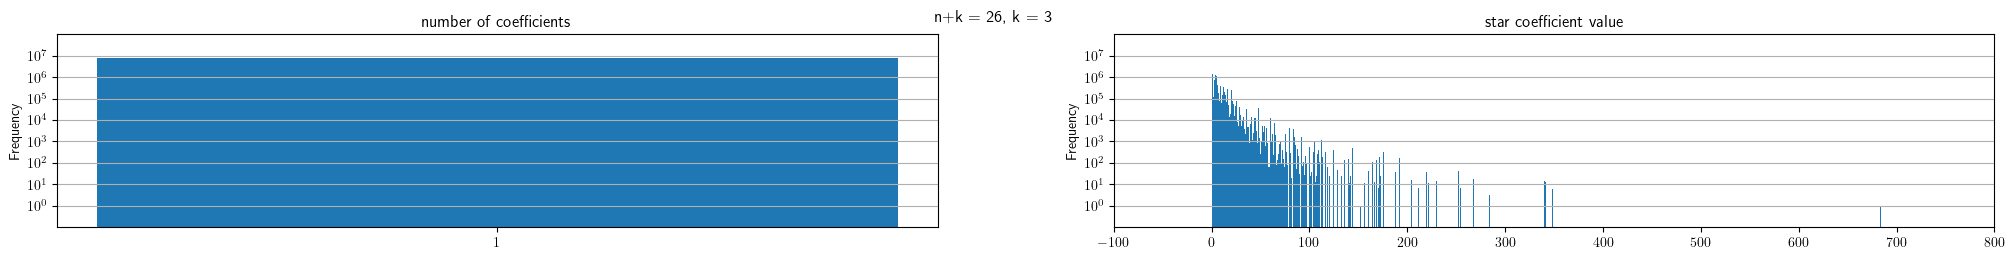

star coefficient value counts: (1, 1402804) (2, 115405) (3, 712684) (4, 1339944) (5, 1162075) ... (284, 3) (340, 14) (341, 13) (348, 6) (684, 1)
----------


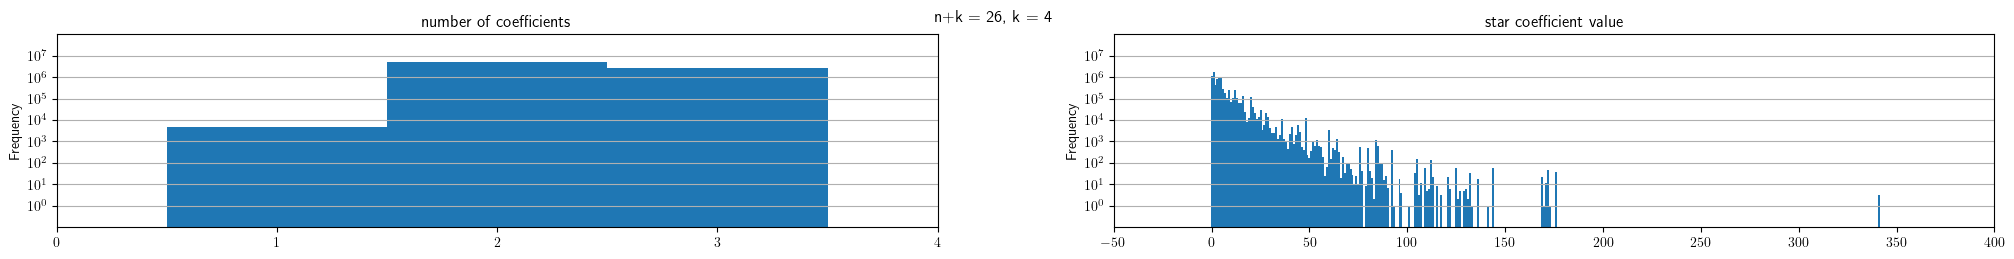

star coefficient value counts: (0, 1103696) (1, 1676633) (2, 441356) (3, 798345) (4, 1063717) ... (171, 12) (172, 46) (173, 1) (176, 38) (341, 3)
----------


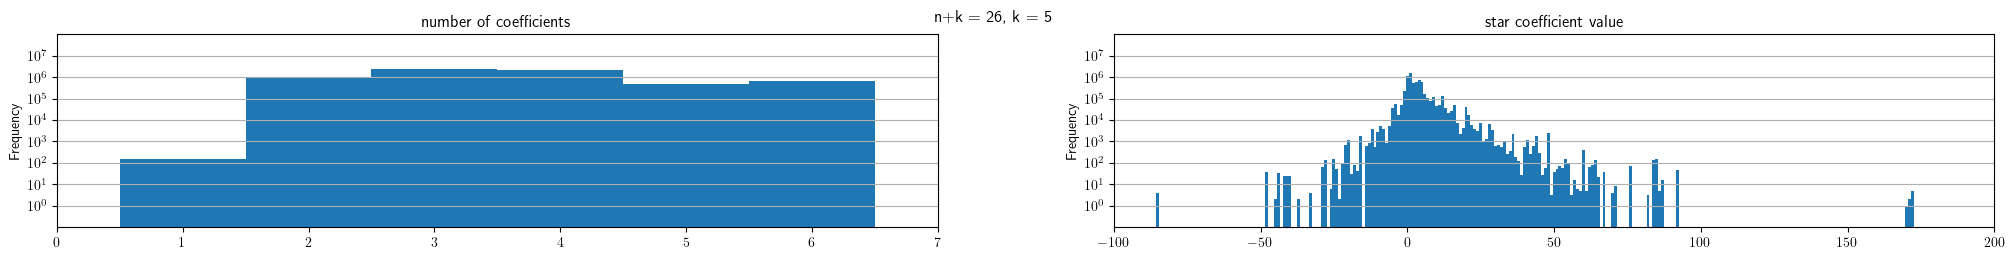

star coefficient value counts: (-85, 4) (-48, 36) (-45, 2) (-44, 35) (-42, 23) ... (87, 16) (92, 45) (170, 1) (171, 2) (172, 5)
----------


In [7]:
plot_stats_histograms(df_stats_c2m2dP, 26)

# Flow Polynomial Coeffcients (Bridges Forbidden)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

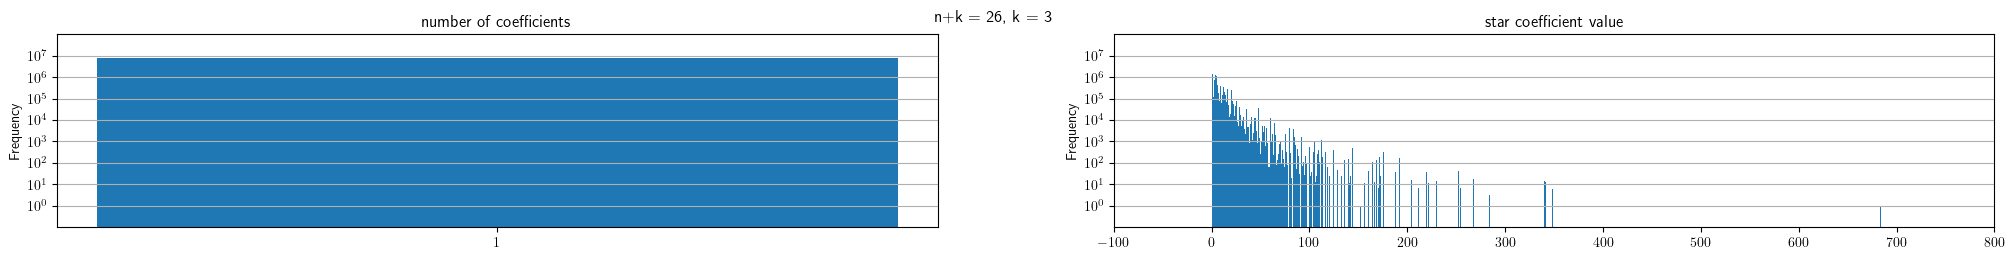

star coefficient value counts: (1, 1402804) (2, 115405) (3, 712684) (4, 1339944) (5, 1162075) ... (284, 3) (340, 14) (341, 13) (348, 6) (684, 1)
----------


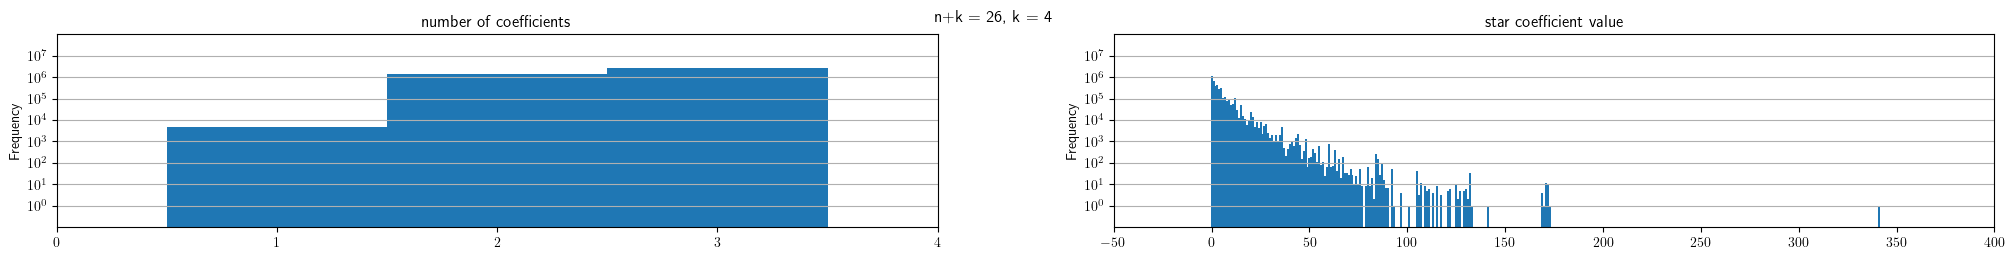

star coefficient value counts: (0, 1103696) (1, 668197) (2, 388633) (3, 434960) (4, 274631) ... (170, 1) (171, 12) (172, 9) (173, 1) (341, 1)
----------


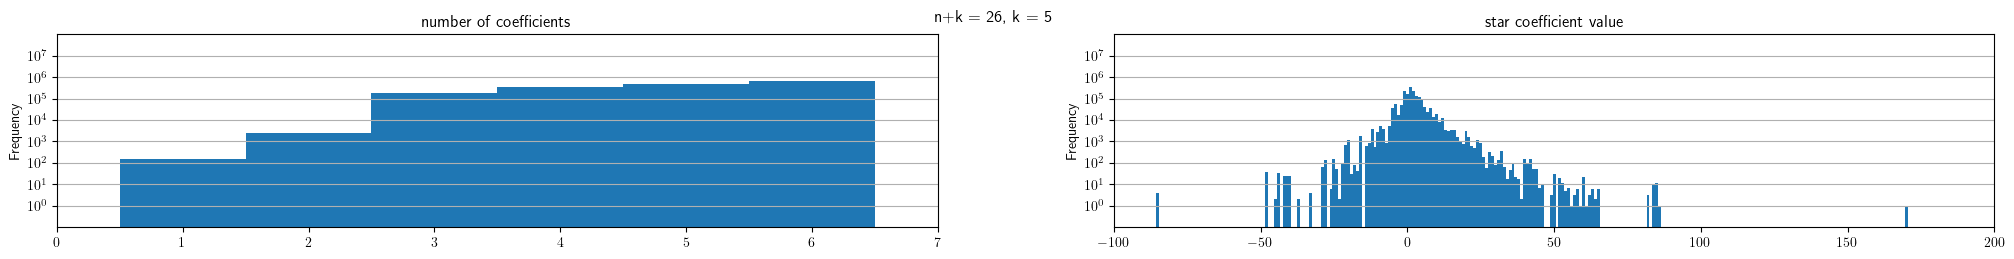

star coefficient value counts: (-85, 4) (-48, 36) (-45, 2) (-44, 35) (-42, 23) ... (82, 3) (84, 9) (85, 11) (86, 1) (170, 1)
----------


In [8]:
plot_stats_histograms(df_stats_dP, 26)

# The Bridgeless 3-pole, 4-pole, and 5-pole With the Largest Star Coefficient Value

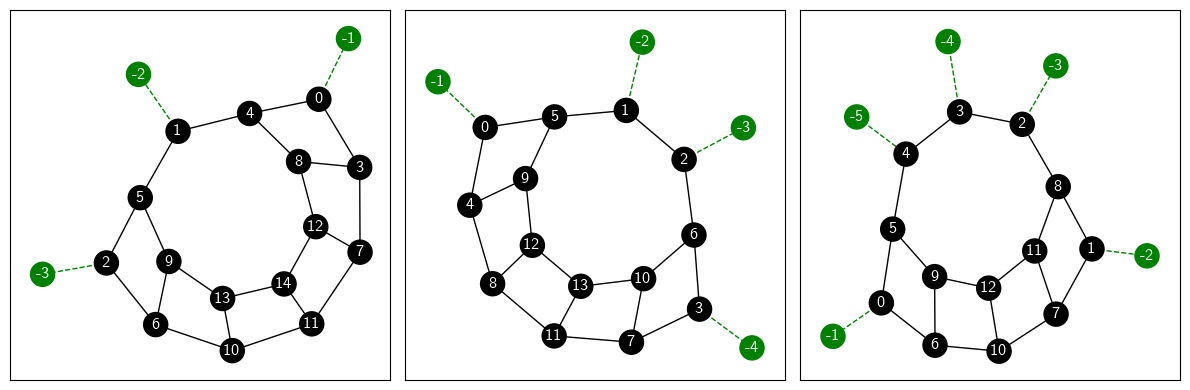

In [9]:
plot_from_files([
    'graphs/max_star/3-18.txt',
    'graphs/max_star/4-18.txt',
    'graphs/max_star/5-18.txt',
])

---

In [10]:
def plot_k4(df, v, name):
    df_v = df[4 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2']).agg({'count': 'sum'}).reset_index()
    df_agg['colorings'] = 21*df_agg.a + 9*(df_agg.b1 + df_agg.b2)

    a, b1, b2 = df_agg.a, df_agg.b1, df_agg.b2

    assert (a >= 0).all()
    assert (a + b1 >= 0).all()
    assert (a + b2 >= 0).all()
    assert (a + b1 + b2 >= 0).all()

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f'n+k = {v}, k = 4')

    xs, ys, zs = a, b1, b2
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlabel('star value')
    ax.set_ylabel('second value')
    ax.set_zlabel('third value')
    min_ = min(xs.min(), ys.min(), zs.min())-5
    max_ = max(xs.max(), ys.max(), zs.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_zlim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, zs, c=df_agg['count'], cmap='copper', norm=mpl.colors.LogNorm(), s=5)
    ax.view_init(15, -135)

    xs, ys = a, b1 + b2
    ax = fig.add_subplot(122)
    ax.set_xlabel('star value')
    ax.set_ylabel('second value + third value')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg['count'], cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    lsp = np.linspace(min_, max_, 500)
    X, Y = np.meshgrid(lsp, lsp)
    Z = 21*X + 9*Y
    Z[(X < 0) | (X + Y < 0)] = np.nan
    ax.imshow(Z, extent=[min_, max_, min_, max_], cmap='Greens', origin='lower')
    ax.text(max_-5, max_-5, 'color stregth = number of colorings', ha='right', va='top')

    plt.grid()
    plt.tight_layout()
    plt.show()

    # for thesis
    fig = plt.figure(figsize=(5, 5))
    xs, ys = a, b1 + b2
    ax = fig.add_subplot(111)
    ax.set_title(f'$n+k = {v}$, $k = 4$')
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b_1+b_2$')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys,c='k', s=3)
    ax.plot([0, -0.001], [0, 5000], color=CYAN)
    ax.plot([0, 1000], [0, -1000], color=MAGENTA)
    plt.grid()
    plt.savefig(f'generated-plots/coef-scatter-{name}.pdf', bbox_inches='tight', dpi=600)
    plt.close()

    return df_agg.sort_values(by='colorings')

# Coeffcient Values for $k=4$ (Bridges Allowed)

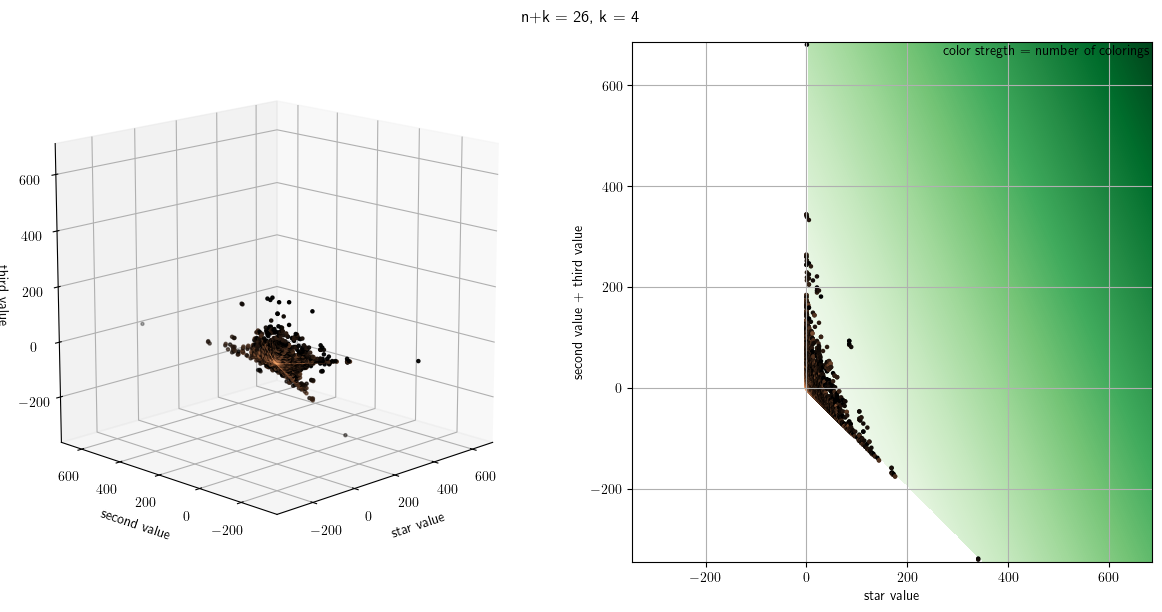

,a,b1,b2,count,colorings
302,1,-1,0,812857,12
307,1,0,-1,195579,12
0,0,1,1,325390,18
648,2,-2,0,39248,24
661,2,0,-2,13475,24
...,...,...,...,...,...
300,0,340,4,4,3096
1977,5,338,-5,4,3102
9228,341,0,-341,2,4092
9227,341,-341,2,1,4110


In [11]:
plot_k4(df_k4_c2m2dP4, 26, 'c2m2dP4')

# Coeffcient Values for $k=4$ (Bridges Forbidden)

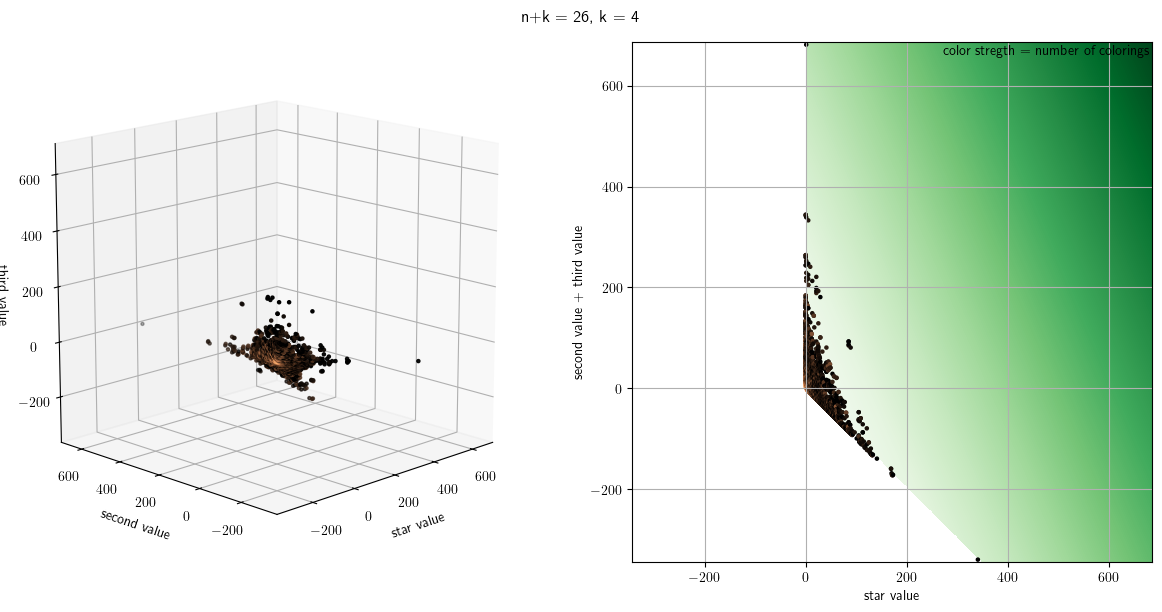

,a,b1,b2,count,colorings
0,0,1,1,325390,18
653,2,-1,-1,33887,24
307,1,0,1,33325,30
312,1,1,0,2555,30
319,1,2,-1,272431,30
...,...,...,...,...,...
296,0,172,172,2,3096
301,0,340,4,4,3096
1970,5,338,-5,4,3102
9065,341,-341,2,1,4110


In [12]:
plot_k4(df_k4_dP4, 26, 'dP4')

# The Bridgeless 4-pole With the Largest Number of Colorings

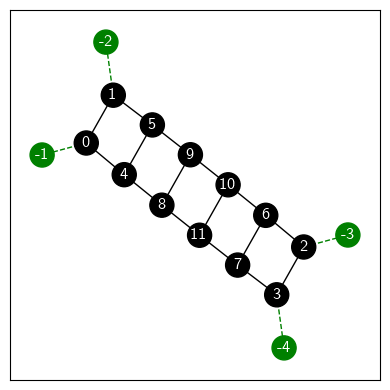

In [13]:
plot_from_files(['graphs/k4_max_colorings/16.txt'])

---

In [14]:
def plot_k5(df, v, name):
    df_v = df[5 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2', 'b3', 'b4', 'b5']).agg({'count': 'sum'}).reset_index()
    a, b1, b2, b3, b4, b5 = df_agg.a, df_agg.b1, df_agg.b2, df_agg.b3, df_agg.b4, df_agg.b5

    for expr in [
        a + b1,   a + b1 + b2,
        a + b2,   a + b2 + b3,
        a + b3,   a + b3 + b4,
        a + b4,   a + b4 + b5,
        a + b5,   a + b5 + b1,
    ]:
        assert (expr >= 0).all()

    fig = plt.figure(figsize=(6, 6))
    fig.suptitle(f'n+k = {v}, k = 5')

    xs, ys = a, b1 + b2 + b3 + b4 + b5
    ax = fig.add_subplot(111)
    ax.set_xlabel('star value')
    ax.set_ylabel('sum of other values')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg['count'], cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    ax.plot([0, -1000], [0, 5000], color=CYAN)
    ax.plot([0, 1000], [0, -2500], color=MAGENTA)
    ax.plot([0, 1000], [0, -2000], color=YELLOW)

    plt.grid()
    plt.tight_layout()
    plt.show()

    # for thesis
    fig = plt.figure(figsize=(5, 5))
    xs, ys = a, b1 + b2 + b3 + b4 + b5
    ax = fig.add_subplot(111)
    ax.set_title(f'$n+k = {v}$, $k = 5$')
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b_1+b_2+b_3+b_4+b_5$')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys,c='k', s=3)
    ax.plot([0, -1000], [0, 5000], color=CYAN)
    ax.plot([0, 1000], [0, -2500], color=MAGENTA)
    ax.plot([0, 1000], [0, -2000], color=YELLOW)
    plt.grid()
    plt.savefig(f'generated-plots/coef-scatter-{name}.pdf', bbox_inches='tight', dpi=600)
    plt.close()

    return df_agg

# Coeffcient Values for $k=5$ (Bridges Allowed)

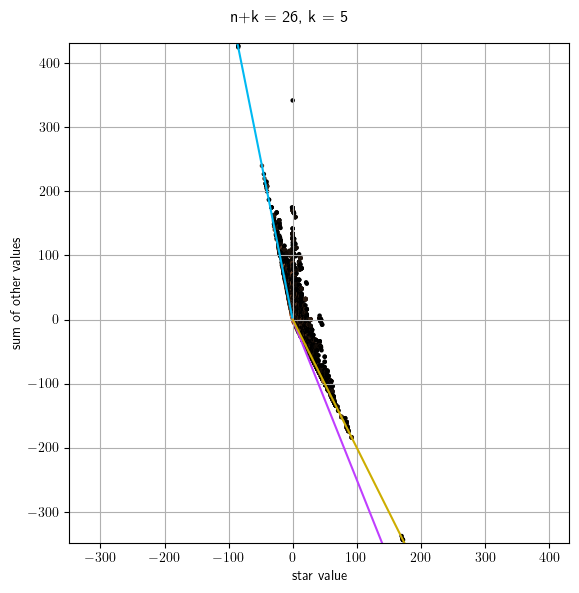

,a,b1,b2,b3,b4,b5,count
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
41638,170,0,-170,1,1,-170,1
41639,171,-170,0,-171,0,-1,2
41640,172,-172,0,-172,0,0,3
41641,172,-172,0,0,-172,0,1


In [15]:
plot_k5(df_k5_c2m2dP5, 26, 'c2m2dP5')

# Coeffcient Values for $k=5$ (Bridges Forbidden)

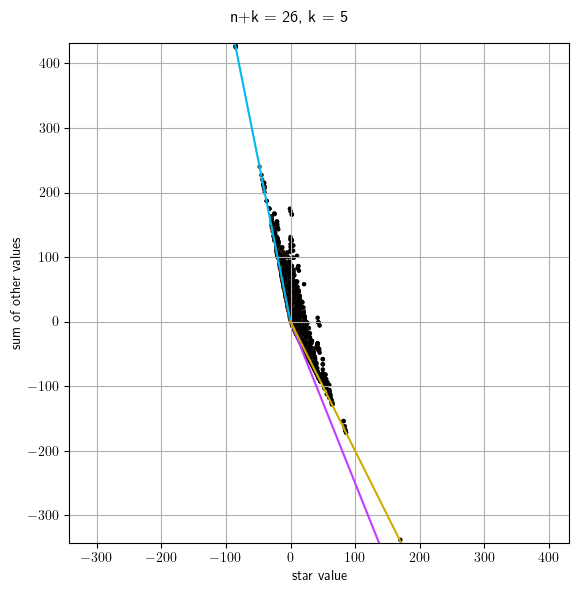

,a,b1,b2,b3,b4,b5,count
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
29341,85,-85,0,0,-85,1,1
29342,85,-85,1,-85,0,0,9
29343,85,-85,2,-84,-1,0,1
29344,86,0,-1,-85,-1,-85,1


In [16]:
plot_k5(df_k5_dP5, 26, 'dP5')

# Empirical Constraint Analysis

In [17]:
def prepare_points(sym, k, v, flags):
    if sym:
        v_to_load = 32 if k == 4 else 34
        assert v <= v_to_load
        df = load_kss(k, f'computed/counts-k{k}ss-{flags}dP{k}-{v_to_load}-1.txt.gz')
    else:
        assert v <= 30
        df = load_k(k, f'computed/counts-k{k}-{flags}dP{k}-30-1.txt.gz')
    df = df[k + df.n <= v]
    df = df.drop(columns=['n', 'count'])
    df = unique_rows(df)
    return df

def get_planes(points):
    hull = ConvexHull(points)
    planes = pd.DataFrame(hull.equations)
    planes = unique_rows(planes)
    planes.columns = points.columns.tolist() + ['offset']
    return planes

def my_isclose(a, b, rtol=1e-6, atol=1e-8):
    return np.isclose(a, b, rtol=rtol, atol=atol)

def float_to_rational(x, max_q=1000):
    assert -1 <= x <= 1 or my_isclose(abs(x), 1)
    for q in range(1, max_q+1):
        p = x*q
        if my_isclose(p, round(p)):
            return True, round(p), q
    return False, None, None

def row_to_integers(row):
    assert my_isclose(row[0], 1)
    ps, qs = [1], [1]
    for x in row[1:]:
        is_rational, p, q = float_to_rational(x)
        if not is_rational:
            return False, []
        ps.append(p)
        qs.append(q)
    common_q = math.lcm(*qs)
    return True, [int(p*(common_q//q)) for p, q in zip(ps, qs)]

def filter_integer_zero_offset_planes(planes):
    # drop planes with non-zero offset
    planes = planes[my_isclose(planes['offset'], 0)].reset_index(drop=True)
    planes = planes.drop(columns='offset')

    # scale each equation so that the first coefficient is 1
    planes = planes.apply(lambda row: row / row['a'], axis=1)

    # convert each equation to integers, dropping those that don't appear to be reasonable
    filtered_rows = []
    for row in planes.values:
        is_integer, integer_row = row_to_integers(row)
        if is_integer:
            filtered_rows.append(integer_row)
    planes = pd.DataFrame(filtered_rows, columns=planes.columns)

    # sort rows primarily by a, then by sum of the other coefs, ten by the other coefs
    planes = planes.assign(sum=planes.sum(axis=1))
    planes = planes.sort_values(['a', 'sum'] + planes.columns.tolist())
    planes = planes.drop(columns='sum').reset_index(drop=True)

    # if there are duplicates by any chance, drop them
    planes = unique_rows(planes)
    return planes

def get_integer_zero_offset_planes(sym, k, v, flags='c2m2'):
    points = prepare_points(sym, k, v, flags)
    planes = get_planes(points)
    filtered_planes = filter_integer_zero_offset_planes(planes)
    return filtered_planes

display(get_integer_zero_offset_planes(False, 4, 30))
display(get_integer_zero_offset_planes(True, 4, 32))

,a,b1,b2
0,1,0,0
1,1,0,1
2,1,1,0
3,1,1,1


,a,b
0,1,0
1,1,1


In [18]:
display(get_integer_zero_offset_planes(False, 5, 30))
display(get_integer_zero_offset_planes(True, 5, 34))

,a,b1,b2,b3,b4,b5
0,1,0,0,0,0,1
1,1,0,0,0,1,0
2,1,0,0,1,0,0
3,1,0,1,0,0,0
4,1,1,0,0,0,0
5,1,0,0,0,1,1
6,1,0,0,1,1,0
7,1,0,1,1,0,0
8,1,1,0,0,0,1
9,1,1,1,0,0,0


,a,b
0,2,1
1,5,1


In [19]:
display(get_integer_zero_offset_planes(True, 6, 34))

,a,b,c,d,e
0,1,0,1,0,0
1,1,1,0,1,1
2,2,1,0,0,1
3,3,1,0,0,0
4,3,0,2,0,0
5,3,1,0,1,0
6,3,1,1,1,0
7,4,2,0,0,1
8,4,2,1,1,1
9,9,3,2,1,3


In [20]:
# get_integer_zero_offset_planes(True, 7, 18)                    # 94
# get_integer_zero_offset_planes(True, 7, 20)                    # 194
# get_integer_zero_offset_planes(True, 7, 22)                    # 242
# get_integer_zero_offset_planes(True, 7, 24)                    # 293
# get_integer_zero_offset_planes(True, 7, 26)                    # 234
# get_integer_zero_offset_planes(True, 7, 28)                    # 175
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 30))  # 140
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 32))  # 138
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 34))  # 125

In [21]:
# get_integer_zero_offset_planes(True, 7, 18)                    # 94
# get_integer_zero_offset_planes(True, 7, 20)                    # 194
# get_integer_zero_offset_planes(True, 7, 22)                    # 242
# get_integer_zero_offset_planes(True, 7, 24)                    # 293
# get_integer_zero_offset_planes(True, 7, 26)                    # 234
# get_integer_zero_offset_planes(True, 7, 28)                    # 175
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 30))  # 140
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 32))  # 138
# df_show_all_rows(get_integer_zero_offset_planes(True, 7, 34))  # 125

# Tightness of the Constraints Given by Minimal Color Sets

In [22]:
def mcs_k4_p1(df):
    # 1111, 1122
    df = unique_rows(df[['a', 'b1', 'b2']])
    a, b1, b2 = df.a, df.b1, df.b2
    df['colorings'] = 21*a + 9*b1 + 9*b2
    df['selected'] = 9*a + 9*b1 + 3*b2
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k4_p1(df_k4_c2m2dP4))
display(mcs_k4_p1(df_k4_dP4))

,a,b1,b2,colorings,selected,ratio
102315,688,-688,0,8256,0,0.000000
102313,684,-684,0,8208,0,0.000000
102304,681,-681,0,8172,0,0.000000
90924,528,-528,0,6336,0,0.000000
90921,520,-520,0,6240,0,0.000000
...,...,...,...,...,...,...
32007,0,1022,6,9252,9216,0.996109
87450,5,1362,-5,12318,12288,0.997565
32130,0,1364,4,12312,12288,0.998051
9307,0,1365,1,12294,12288,0.999512


,a,b1,b2,colorings,selected,ratio
101875,685,-685,2,8238,6,0.000728
29247,683,-682,-1,8196,6,0.000732
90487,525,-525,2,6318,6,0.000950
89695,517,-517,2,6222,6,0.000964
85985,485,-485,2,5838,6,0.001028
...,...,...,...,...,...,...
31733,0,1022,6,9252,9216,0.996109
87019,5,1362,-5,12318,12288,0.997565
31856,0,1364,4,12312,12288,0.998051
9144,0,1365,1,12294,12288,0.999512


In [23]:
def mcs_k4_p2(df):
    # 1212, 1221
    df = unique_rows(df[['a', 'b1', 'b2']])
    a, b1, b2 = df.a, df.b1, df.b2
    df['colorings'] = 21*a + 9*b1 + 9*b2
    df['selected'] = 12*a + 6*b1
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k4_p2(df_k4_c2m2dP4))
display(mcs_k4_p2(df_k4_dP4))

,a,b1,b2,colorings,selected,ratio
32982,1,-1,682,6150,6,0.000976
9240,0,1,341,3078,6,0.001949
2941,1,-1,170,1542,6,0.003891
870,0,1,85,774,6,0.007752
326,1,-1,42,390,6,0.015385
...,...,...,...,...,...,...
102307,681,10,-681,8262,8232,0.996369
102316,688,0,-688,8256,8256,1.000000
42963,1365,0,-1365,16380,16380,1.000000
33417,1,2730,-1,24582,16392,0.666829


,a,b1,b2,colorings,selected,ratio
32708,1,-1,682,6150,6,0.000976
9077,0,1,341,3078,6,0.001949
2844,1,-1,170,1542,6,0.003891
819,0,1,85,774,6,0.007752
292,1,-1,42,390,6,0.015385
...,...,...,...,...,...,...
71457,341,690,-341,10302,8232,0.799068
71468,345,682,-345,10278,8232,0.800934
101869,681,10,-681,8262,8232,0.996369
33144,1,2730,-1,24582,16392,0.666829


In [24]:
def mcs_k5_p1(df):
    # 11231, 11213, 11123
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(3*a + 1*b1 + 3*b2 + 1*b3)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p1(df_k5_c2m2dP5))
display(mcs_k5_p1(df_k5_dP5))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
700570,684,0,-684,0,0,-684,16416,0,0.000000
236134,0,0,0,0,345,341,12348,0,0.000000
236236,0,0,0,0,681,5,12348,0,0.000000
599795,4,0,-4,0,-4,680,12336,0,0.000000
600081,4,0,-4,0,680,-4,12336,0,0.000000
...,...,...,...,...,...,...,...,...,...
325658,12,0,504,-12,0,-12,9360,9216,0.984615
239197,0,0,509,9,0,0,9324,9216,0.988417
683006,6,0,508,-6,0,-6,9288,9216,0.992248
602083,4,0,680,-4,0,-4,12336,12288,0.996109


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
564554,682,0,-682,1,1,-682,16404,6,0.000366
192661,0,0,0,1,341,341,12294,6,0.000488
98280,341,1,-341,0,0,-341,8202,6,0.000732
192663,0,0,0,1,426,1,7704,6,0.000779
47098,1,-1,0,-1,170,172,6180,6,0.000971
...,...,...,...,...,...,...,...,...,...
440486,3,-2,340,-3,0,-1,6192,6144,0.992248
134176,-1,1,341,3,1,1,6186,6144,0.993210
214232,1,2,340,-1,0,-1,6180,6144,0.994175
361775,2,-2,341,341,-2,0,12324,8208,0.666018


In [25]:
def mcs_k5_p2(df):
    # 12113, 12131, 12223, 12232
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(4*a + 1*b1 + 2*b3 + 2*b4)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p2(df_k5_c2m2dP5))
display(mcs_k5_p2(df_k5_dP5))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
60710,1,-1,0,0,-1,341,6162,6,0.000974
239874,0,1,0,0,0,341,6156,6,0.000975
10669,-1,1,1,1,1,171,3090,6,0.001942
175711,-1,1,171,1,1,1,3090,6,0.001942
60706,1,-1,0,-1,0,170,3084,6,0.001946
...,...,...,...,...,...,...,...,...,...
575467,340,0,-340,0,8,-340,8304,8256,0.994220
575468,340,0,-340,8,0,-340,8304,8256,0.994220
575501,348,0,-348,0,0,-348,8352,8352,1.000000
700566,682,0,-682,1,1,-682,16404,16392,0.999268


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
47100,1,-1,0,0,-1,341,6162,6,0.000974
6821,-1,1,1,1,1,171,3090,6,0.001942
133730,-1,1,171,1,1,1,3090,6,0.001942
196532,0,1,5,0,0,85,1638,6,0.003663
207632,1,-1,2,0,-1,85,1590,6,0.003774
...,...,...,...,...,...,...,...,...,...
360398,2,-2,0,-2,681,1,12324,8184,0.664070
339800,171,0,-171,341,-1,-170,10242,8184,0.799063
133387,-1,1,1,683,1,1,12306,8190,0.665529
98280,341,1,-341,0,0,-341,8202,8190,0.998537


In [26]:
def mcs_k5_p3(df):
    # 12333, 12311, 11231, 11123, 12223
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(5*a + 2*b1 + 2*b2 + 2*b3 + 2*b4 + 2*b5)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p3(df_k5_c2m2dP5))
display(mcs_k5_p3(df_k5_dP5))

display(mcs_k5_p3(df_k5_c2m2dP5).sort_values(by=['ratio', 'colorings'], ascending=[True, False]))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
25,1,-1,0,-1,0,0,24,6,0.250000
29,1,-1,0,0,-1,0,24,6,0.250000
36,1,0,-1,0,-1,0,24,6,0.250000
38,1,0,-1,0,0,-1,24,6,0.250000
42,1,0,0,-1,0,-1,24,6,0.250000
...,...,...,...,...,...,...,...,...,...
250818,0,681,5,0,0,0,12348,8232,0.666667
212251,-341,341,341,341,341,341,10230,10230,1.000000
212252,-341,341,341,341,341,343,10266,10254,0.998831
212253,-341,343,341,341,341,341,10266,10254,0.998831


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
21,2,-1,-1,-1,0,-1,48,12,0.250000
22,2,-1,-1,0,-1,-1,48,12,0.250000
73,2,-1,0,-1,-1,-1,48,12,0.250000
78,2,0,-1,-1,-1,-1,48,12,0.250000
248,2,-1,-1,-1,-1,0,48,12,0.250000
...,...,...,...,...,...,...,...,...,...
192661,0,0,0,1,341,341,12294,8196,0.666667
133387,-1,1,1,683,1,1,12306,8214,0.667479
169466,-341,341,341,341,341,341,10230,10230,1.000000
169467,-341,341,341,341,341,343,10266,10254,0.998831


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
700568,684,-684,0,-684,0,0,16416,4104,0.25
700569,684,-684,0,0,-684,0,16416,4104,0.25
700570,684,0,-684,0,0,-684,16416,4104,0.25
700567,683,-682,0,-683,0,-1,16392,4098,0.25
575499,348,-348,0,-348,0,0,8352,2088,0.25
...,...,...,...,...,...,...,...,...,...
92,-5,5,5,5,5,5,150,150,1.00
7,-4,4,4,4,4,4,120,120,1.00
292,-3,3,3,3,3,3,90,90,1.00
921,-2,2,2,2,2,2,60,60,1.00


In [27]:
def mcs_k6_p1(df):
    # 6-cycle
    df = unique_rows(df[[
        'a',
        'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
        'c1', 'c2', 'c3',
        'd1', 'd2', 'd3',
        'e1', 'e2'
    ]])
    a = df.a
    b = df.b1 + df.b2 + df.b3 + df.b4 + df.b5 + df.b6
    c = df.c1 + df.c2 + df.c3
    d = df.d1 + df.d2 + df.d3
    e = df.e1 + df.e2
    df['colorings'] = 183*a + 63*b + 36*c + 27*d + 27*e
    df['selected'] = 63*a +33*b + 12*c + 21*d + 21*e
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k6_p1(df_k6_c2m2dP6))
display(mcs_k6_p1(df_k6_dP6))

display(mcs_k6_p1(df_k6_c2m2dP6).sort_values(by=['ratio', 'colorings'], ascending=[True, False]))

,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
44,1,-1,0,-1,0,-1,0,0,0,0,0,0,0,2,0,48,6,0.125000
48,1,-1,0,-1,0,0,0,0,0,-1,0,0,0,1,0,48,6,0.125000
53,1,-1,0,0,-1,0,0,-1,0,0,1,0,0,0,0,48,6,0.125000
54,1,-1,0,0,-1,0,0,0,0,-1,1,0,0,0,0,48,6,0.125000
59,1,-1,0,0,0,-1,0,-1,0,0,0,0,0,1,0,48,6,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452816,-341,170,171,171,171,170,171,170,171,171,0,0,-1,-170,-172,11280,11250,0.997340
452815,-340,170,170,170,170,170,170,170,170,170,0,1,1,-169,-169,11328,11304,0.997881
452817,-344,172,172,172,172,172,172,172,172,172,0,0,0,-172,-172,11352,11352,1.000000
585758,1,-1,0,0,0,-1,0,-1,0,0,0,0,341,1,341,18462,14328,0.776081


,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
1071,4,0,-2,-2,-1,-2,-2,0,-2,-1,0,1,1,1,2,192,24,0.125000
4415,4,-1,-2,-2,0,-2,-2,-1,-2,0,0,1,1,2,1,192,24,0.125000
4416,4,-1,-2,-2,0,-2,-2,0,-2,-1,0,1,1,2,1,192,24,0.125000
4507,4,-2,0,-2,-2,-1,-2,0,-1,-2,1,0,1,2,1,192,24,0.125000
4604,4,0,-2,-2,-1,-2,-2,-1,-2,0,0,1,1,1,2,192,24,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226885,0,0,0,0,0,0,0,0,0,0,85,1,1,1,426,13878,10794,0.777778
183958,-341,170,171,171,171,170,171,170,171,171,0,0,-1,-170,-172,11280,11250,0.997340
183957,-340,170,170,170,170,170,170,170,170,170,0,1,1,-169,-169,11328,11304,0.997881
183959,-344,172,172,172,172,172,172,172,172,172,0,0,0,-172,-172,11352,11352,1.000000


,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
1144098,341,-341,0,-341,0,-341,0,0,0,0,0,0,0,682,0,16368,2046,0.125
1144101,341,-341,0,0,0,-341,0,-341,0,0,0,0,0,341,0,16368,2046,0.125
1144103,341,0,-341,0,-341,0,0,-341,0,0,0,0,0,0,341,16368,2046,0.125
1144105,341,0,-341,0,0,-341,0,-341,0,0,0,341,0,0,0,16368,2046,0.125
1144106,341,0,-341,0,0,-341,0,0,-341,0,0,341,0,0,0,16368,2046,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,-10,5,5,5,5,5,5,5,5,5,0,0,0,-5,-5,330,330,1.000
159,-8,4,4,4,4,4,4,4,4,4,0,0,0,-4,-4,264,264,1.000
1951,-6,3,3,3,3,3,3,3,3,3,0,0,0,-3,-3,198,198,1.000
6818,-4,2,2,2,2,2,2,2,2,2,0,0,0,-2,-2,132,132,1.000
